Train dataset size: 3680
Test dataset size: 3669
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
       BatchNorm2d-4         [-1, 64, 256, 256]             128
              ReLU-5         [-1, 64, 256, 256]               0
           Dropout-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
          Dropout-13        [-1, 128, 128, 128]       

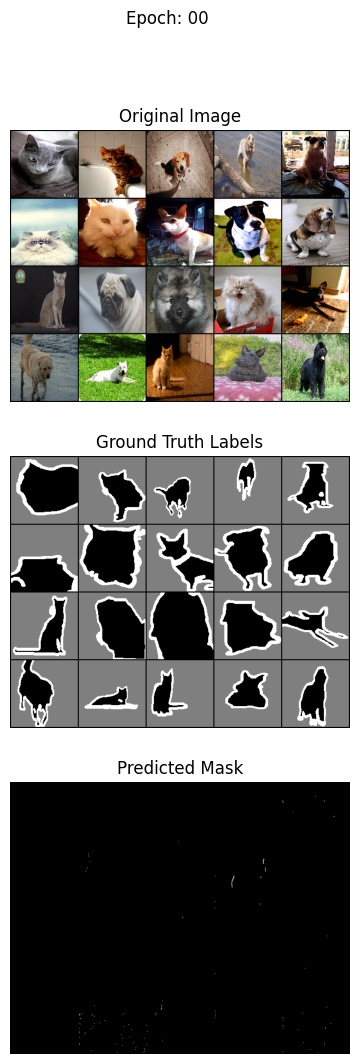

Starting training...


In [3]:
from mainUnet import *
import os
import torchvision.transforms as T

OUTPUT_PATH = 'runs/Unet'
MODEL_PATH = os.path.join(OUTPUT_PATH, 'Unet_model.pth')
HISTORY_LOSS_PATH = os.path.join(OUTPUT_PATH, 'unet_history.pickle')
HISTORY_METRICS_PATH = os.path.join(OUTPUT_PATH, 'unet_metrics.pickle')

HISTORY_PLOT_PATH = os.path.join(OUTPUT_PATH, 'plot_history.png')
PRED_PLOT_PATH = os.path.join(OUTPUT_PATH, 'pred.png')
METRICS_PLOT_PATH = os.path.join(OUTPUT_PATH, 'plot_metrics.png')

In [4]:
model = to_device(UNet())
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

Train dataset size: 3680
Test dataset size: 3669
5


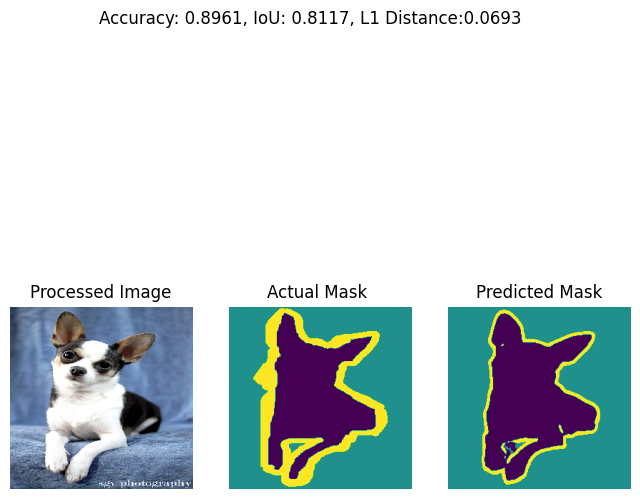

In [8]:
import random

BACH_SIZE_TEST = 5
# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
test = os.path.join('oxford-iiit-pet', 'test')
test_dataset = torchvision.datasets.OxfordIIITPet(root=test, split="test", target_types="segmentation", download=True)


#(train_pets_input, train_pets_target) = train_dataset[0]

class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={self.device})"

class PetsDataset(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        
        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if
        
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)
    
# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

pets_test = PetsDataset(
    root=test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

#reduce the size of the dataset for testing
#pets_train = torch.utils.data.Subset(pets_train, range(0, 100))
#pets_test = torch.utils.data.Subset(pets_test, range(0, 100))
print(f"Train dataset size: {len(pets_train)}")
print(f"Test dataset size: {len(pets_test)}")

pets_test_dataloader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=BACH_SIZE_TEST,
    shuffle=True,
)


(test_pets_inputs, test_pets_targets) = next(iter(pets_test_dataloader))

model.eval()
model.to('cpu')
transform = T.ToPILImage()
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_dataloader))
print(len(test_pets_inputs))
fig, arr = plt.subplots(1, 3, figsize=(8, 8)) 

#random index
index = random.randint(0, len(test_pets_inputs)-1)

img = test_pets_inputs[index].unsqueeze(0)
pred_y = model(img)
pred_yy = nn.Softmax(dim=1)(pred_y)
pred_mask = pred_yy.argmax(dim=1)
pred_mask = pred_mask.unsqueeze(1)
pred_mask_f= pred_mask.to(torch.float)


arr[0].imshow(transform(test_pets_inputs[index]))
arr[0].set_title('Processed Image')
arr[0].axis('off')
arr[1].imshow(test_pets_targets[index].cpu().numpy().squeeze(0))
arr[1].set_title('Actual Mask ')
arr[1].axis('off')
arr[2].imshow(pred_mask_f.squeeze(0).squeeze(0))
arr[2].set_title('Predicted Mask')
arr[2].axis('off')


accuracy = prediction_accuracy(pred_y,test_pets_targets[index].unsqueeze(0))
iou = IoUMetric(pred_y, test_pets_targets[index].unsqueeze(0))
l1distance = L1DistanceMetric(pred_y, test_pets_targets[index].unsqueeze(0))

title=f'Accuracy: {accuracy:.4f}, IoU: {iou:.4f}, L1 Distance:{l1distance:.4f}'

plt.suptitle(title)

#save the plot
plt.savefig(PRED_PLOT_PATH)

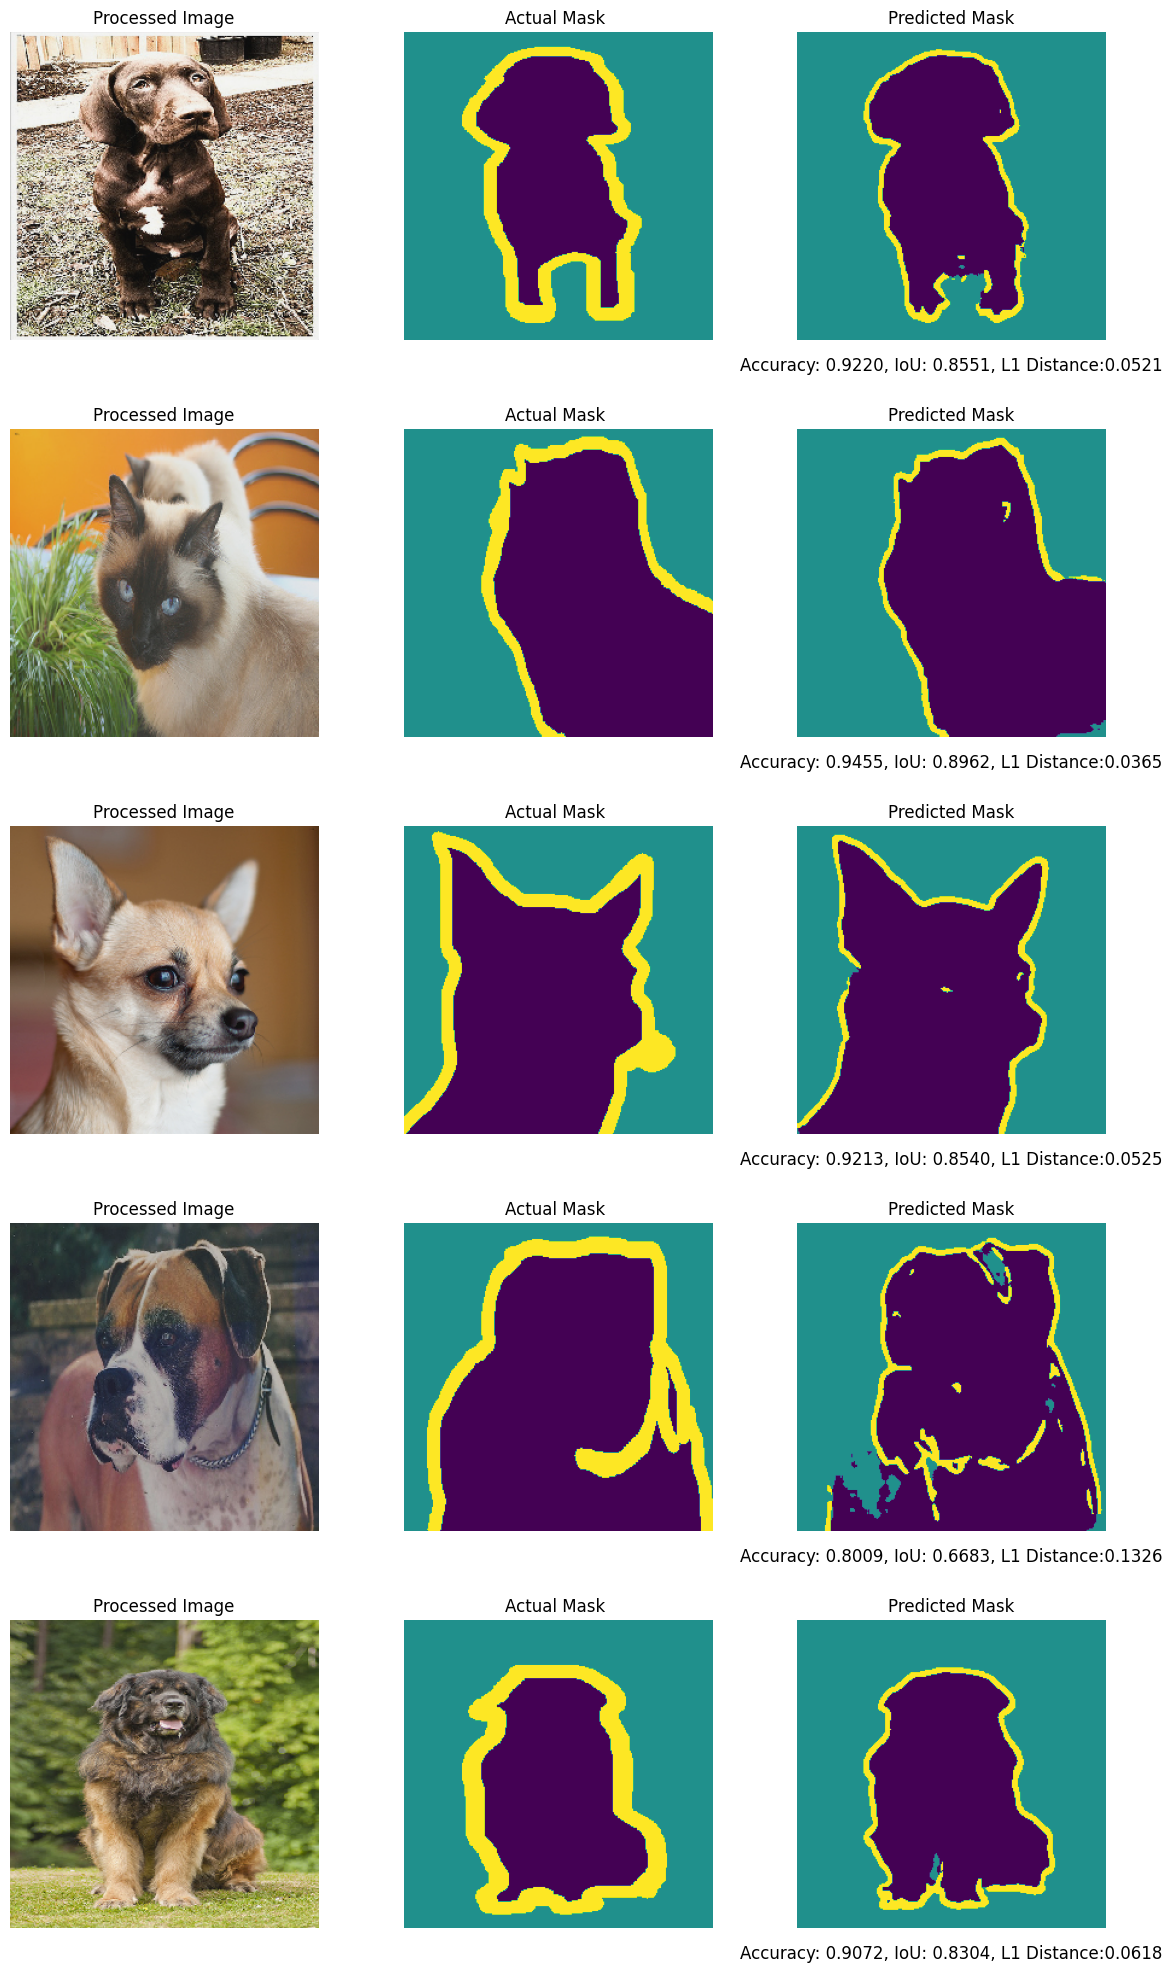

In [9]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import random

# Definire la dimensione del batch per il test
BATCH_SIZE_TEST = 5

# Oxford IIIT Pets Segmentation dataset caricato tramite torchvision
test = os.path.join('oxford-iiit-pet', 'test')
test_dataset = torchvision.datasets.OxfordIIITPet(root=test, split="test", target_types="segmentation", download=True)

# Classe ToDevice per inviare l'oggetto al dispositivo specificato
class ToDevice(torch.nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={self.device})"

# Classe PetsDataset per caricare il dataset e applicare le trasformazioni
class PetsDataset(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        
        # Trasformazioni comuni applicate sia all'input che alle etichette
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

# Funzione per creare un trimap per la segmentazione
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

# Funzione per convertire gli argomenti in dizionario
def args_to_dict(**kwargs):
    return kwargs

# Trasformazioni da applicare al dataset
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Creazione del dataset di test
pets_test = PetsDataset(
    root=test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

# Creazione del dataloader per il test
pets_test_dataloader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=BATCH_SIZE_TEST,
    shuffle=True,
)

# Caricamento di un batch di immagini e maschere dal dataloader
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_dataloader))

# Valutazione del modello
model.eval()
model.to('cpu')
transform = T.ToPILImage()

# Visualizzazione delle immagini, maschere reali e maschere previste
fig, axs = plt.subplots(BATCH_SIZE_TEST, 3, figsize=(12, 4 * BATCH_SIZE_TEST))

for i in range(BATCH_SIZE_TEST):
    img = test_pets_inputs[i].unsqueeze(0)
    pred_y = model(img)
    pred_yy = nn.Softmax(dim=1)(pred_y)
    pred_mask = pred_yy.argmax(dim=1)
    pred_mask = pred_mask.unsqueeze(1)
    pred_mask_f = pred_mask.to(torch.float)

    axs[i, 0].imshow(transform(test_pets_inputs[i]))
    axs[i, 0].set_title('Processed Image')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(test_pets_targets[i].cpu().numpy().squeeze(0))
    axs[i, 1].set_title('Actual Mask ')
    axs[i, 1].axis('off')
    axs[i, 2].imshow(pred_mask_f.squeeze(0).squeeze(0))
    axs[i, 2].set_title('Predicted Mask')
    axs[i, 2].axis('off')

    accuracy = prediction_accuracy(pred_y, test_pets_targets[i].unsqueeze(0))
    iou = IoUMetric(pred_y, test_pets_targets[i].unsqueeze(0))
    l1distance = L1DistanceMetric(pred_y, test_pets_targets[i].unsqueeze(0))
    title = f'Accuracy: {accuracy:.4f}, IoU: {iou:.4f}, L1 Distance:{l1distance:.4f}'
    axs[i, 2].text(0.5, -0.1, title, transform=axs[i, 2].transAxes, fontsize=12, ha='center')

plt.tight_layout()

# Salvataggio della figura
PRED_PLOT_PATH = 'predictions_plot.png'
plt.savefig(PRED_PLOT_PATH)
plt.show()


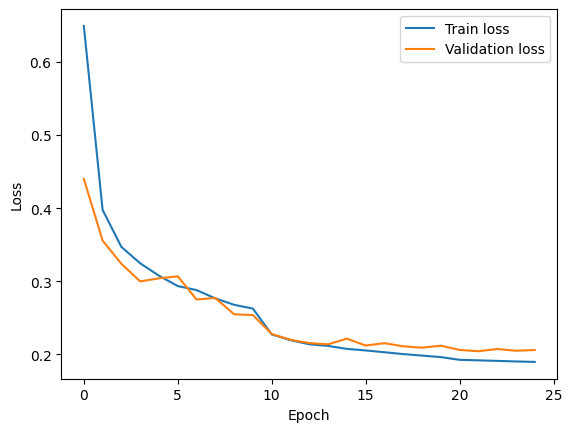

In [10]:
#load history
import pickle
with open(HISTORY_LOSS_PATH, 'rb') as f:
    history_loss = pickle.load(f)

# Plot the training history
plt.figure()
plt.plot(history_loss['train_loss'], label='Train loss')
plt.plot(history_loss['test_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig(HISTORY_PLOT_PATH)




In [ ]:
"""load metrics
with open(HISTORY_METRICS_PATH, 'rb') as f:
    history_metrics = torch.load(f)

# Plot the metrics history
plt.figure()
plt.plot(history_metrics['Accuracy'], label='Accuracy')
plt.plot(history_metrics['Iou'], label='IoU')
plt.plot(history_metrics['L1 Distance'], label='L1 Distance')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend(loc='upper right')
plt.savefig(METRICS_PLOT_PATH)"""


In [12]:
#create zip for gif
!zip -r unet_training_progress_images.zip runs/Unet/unet_training_progress_images



  adding: runs/Unet/unet_training_progress_images/ (stored 0%)
  adding: runs/Unet/unet_training_progress_images/epoch_22.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_23.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_09.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_21.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_20.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_08.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_24.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_18.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_19.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_25.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_17.png (deflated 3%)
  adding: runs/Unet/unet_training_progress_images/epoch_03.png (deflated 3%)
  adding: run

/var/folders/ts/3n8g174j4hl56qjlwd31sqmh0000gn/T/ipykernel_1738/3140333748.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'runs/Unet/unet_training_progress_images/{filename}'))


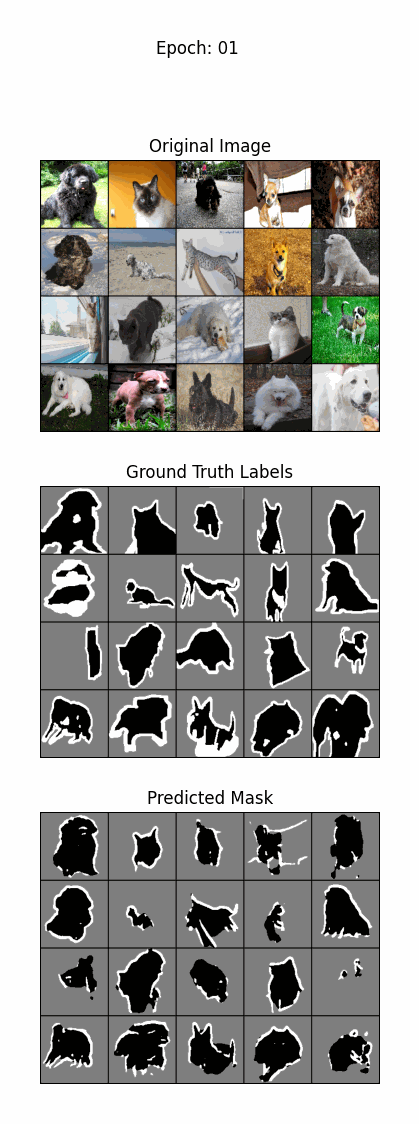

In [13]:
#make a gif from the images

import imageio
import os

images = []
filenames = os.listdir('runs/Unet/unet_training_progress_images')
filenames.sort()
for filename in filenames:
    images.append(imageio.imread(f'runs/Unet/unet_training_progress_images/{filename}'))   
imageio.mimsave('runs/Unet/unet_training_progress_images/unet_training_progress.gif', images, duration=0.5)



# Display the GIF
from IPython.display import Image

Image(filename='runs/Unet/unet_training_progress_images/unet_training_progress.gif')